In [1]:
from maxwellbloch import mb_solve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("dark")

import numpy as np
from scipy import integrate

In [7]:
def store(pulse_fwhm, off, on, fwhm, tmin, tmax, tsteps, strength):
    mb_solve_json = """
    {
      "atom": {
        "decays": [
          { "channels": [[0,1]],
            "rate": 6.0
          },
          { "channels": [[1,2]],
            "rate": 2.0e-3
          }
        ],
        "fields": [
          {
            "coupled_levels": [[0, 1]],
            "detuning": 0.001,
            "detuning_positive": true,
            "label": "probe",
            "rabi_freq": 1.0e-1,
            "rabi_freq_t_args":
              {
                 "ampl": 1.0,
                 "centre": 0.0,
                 "fwhm": """ + pulse_fwhm + """
              },
            "rabi_freq_t_func": "gaussian"
          },
          {
            "coupled_levels": [[1, 2]],
            "detuning": 0.001,
            "detuning_positive": true,
            "label": "coupling",
            "rabi_freq": 4.0,
            "rabi_freq_t_args":
            {
              "ampl": 1.0,
              "fwhm": """ + fwhm + """,
              "off": """ + off + """,
              "on": """ + on + """
              },
            "rabi_freq_t_func": "ramp_offon"
          }
        ],
        "num_states": 3
      },
      "t_min": """ + tmin + """,
      "t_max": """ + tmax + """,
      "t_steps": """ + tsteps + """,
      "z_min": -0.05,
      "z_max": 1.05,
      "z_steps": 70,
      "z_steps_inner": 3,
      "num_density_z_func": "gaussian",
      "num_density_z_args": {
        "ampl": 1.0,
        "fwhm": 0.5,
        "centre": 0.5
      },
      "interaction_strengths": [""" + strength + """, """ + strength + """]

    }
    """
    mb_solve_0 = mb_solve.MBSolve().from_json_str(mb_solve_json)
    %time Omegas_zt, states_zt = mb_solve_0.mbsolve(recalc=False)
    return mb_solve_0.tlist, mb_solve_0.zlist, mb_solve_0.Omegas_zt[0], mb_solve_0.Omegas_zt[1], mb_solve_0.states_zt
    

In [3]:
def plot(t, z, Omega_p, Omega_c):    
    
    fig = plt.figure(1, figsize=(8, 6))

    # Probe
    ax = fig.add_subplot()
    
    cf = ax.contourf(t, z,
                     np.abs(Omega_p/(2*np.pi)),
                     cmap=plt.cm.Blues)
    ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
    ax.set_ylabel('Distance ($L$)')
    ax.text(0.02, 0.95, 'Probe',
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, color='grey', fontsize=16)
    plt.colorbar(cf)

    ax.axhline(y=0, c='grey', lw=1.0, ls='dotted')
    ax.axhline(y=1, c='grey', lw=1.0, ls='dotted')
    plt.tight_layout();
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    
    mxm = np.max(np.real(Omega_p[0]))
    t_scale = 1/38
    ax2.plot(t*t_scale, np.real(Omega_c[0]/mxm), color='black', linestyle='dashed', linewidth=0.5, label='Coupling')
    ax1.plot(t*t_scale, np.real(Omega_p[0])/mxm, label='Input Pulse')
    ax1.plot(t*t_scale, np.real(Omega_p[-1])/mxm, label='Ouput Pulse')
    
    ax1.set_xlabel(r'Time $(\mu s)$', fontsize=25)  
    ax1.set_ylabel(r'$\Omega_p/\tilde{\Omega_p}$', fontsize=25)
    ax2.set_ylabel(r'$\Omega_c/\tilde{\Omega_p}$', fontsize=25)
    ax1.legend()
    ax2.legend(loc=9)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)

In [8]:
pulse_fwhm = "20"
off = "5"
on = "40"
fwhm = "2"
tmin = "-30"
tmax = "100"
tsteps = "80"
strength = "400"

test = store(pulse_fwhm, off, on, fwhm, tmin, tmax, tsteps, strength)

10.0%. Run time:  35.10s. Est. time left: 00:00:05:15
20.0%. Run time:  73.23s. Est. time left: 00:00:04:52
30.0%. Run time: 112.24s. Est. time left: 00:00:04:21
40.0%. Run time: 149.88s. Est. time left: 00:00:03:44
50.0%. Run time: 187.35s. Est. time left: 00:00:03:07
60.0%. Run time: 225.59s. Est. time left: 00:00:02:30
70.0%. Run time: 264.63s. Est. time left: 00:00:01:53
80.0%. Run time: 303.33s. Est. time left: 00:00:01:15
90.0%. Run time: 343.92s. Est. time left: 00:00:00:38
Total run time: 383.57s
Wall time: 6min 23s


TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

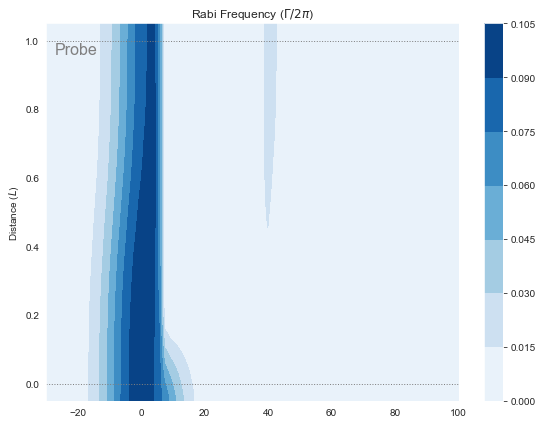

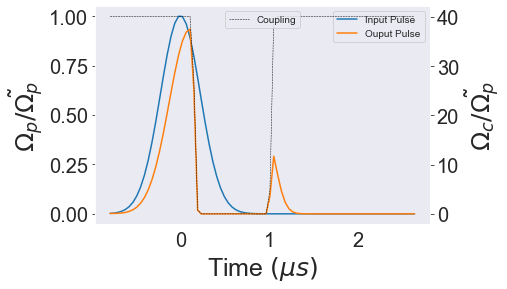

In [9]:
plot(test[0], test[1], test[2], test[3])

In [ ]:
def integrate(Omega_p, t):
    I = np.trapz(np.real(Omega_p), t, dx=0.01)
    return I

In [ ]:
def vary_storage_time(pulse_fwhm, off, storage_times_list, fwhm, tmin, tmax, tsteps, strength):
    # what is the input area?
    out_array = np.array([])
    solutions = np.array([])
    for i in storage_times_list:
        on = str(i)
        # tmax = storage time + something (can be optimised) but this might change integration
        solve = store(pulse_fwhm, off, on, fwhm, tmin, tmax, tsteps, strength)
        solutions = np.append(solutions, solve)
        out_I = integrate(solve[2][-1], solve[0]) # there is an offset
        out_array = np.append(out_array, out_I)
    
    return out_array, solutions

In [ ]:
list_1 = np.linspace(40, 300, 10)
results = vary_storage_time("10", "5", list_1, "2", "-30", "400", "80", "400")